
IsoForest - Repetitive anomaly cell prediction report (≥20% anomaly days):
              precision    recall  f1-score   support

           0       1.00      0.35      0.52       326
           1       0.00      0.00      0.00         0

    accuracy                           0.35       326
   macro avg       0.50      0.17      0.26       326
weighted avg       1.00      0.35      0.52       326


SVM - Repetitive anomaly cell prediction report (≥20% anomaly days):
              precision    recall  f1-score   support

           0       1.00      0.02      0.04       326
           1       0.00      0.00      0.00         0

    accuracy                           0.02       326
   macro avg       0.50      0.01      0.02       326
weighted avg       1.00      0.02      0.04       326


LOF - Repetitive anomaly cell prediction report (≥20% anomaly days):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       326

    accuracy        

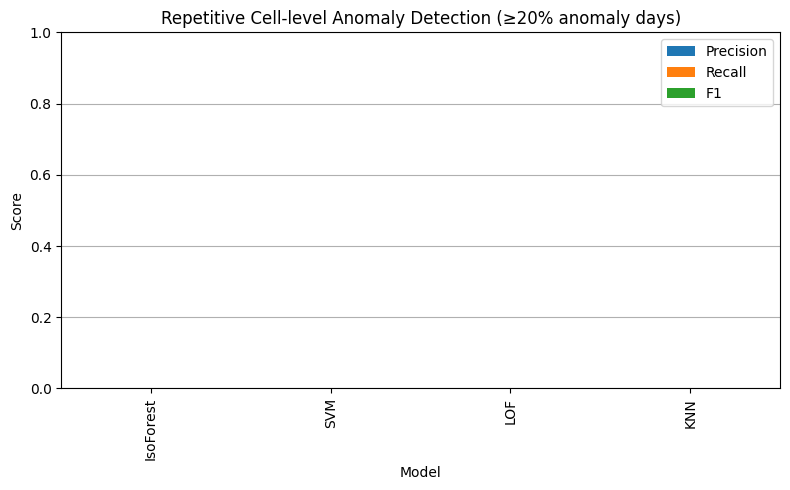

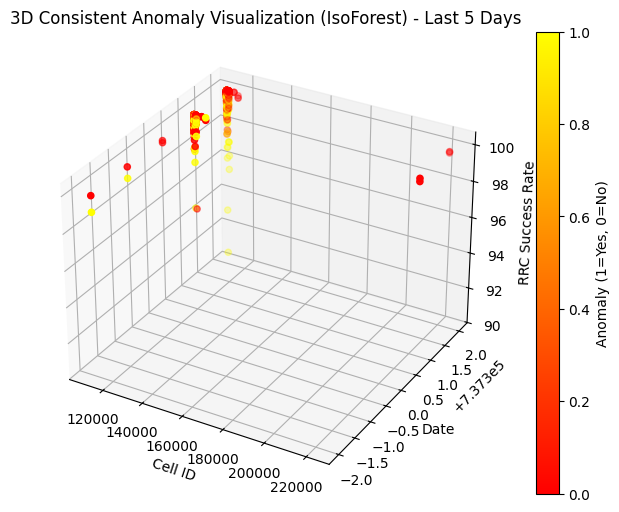

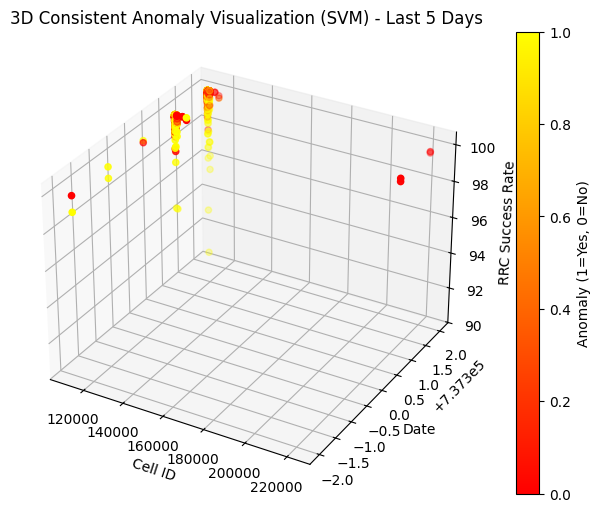

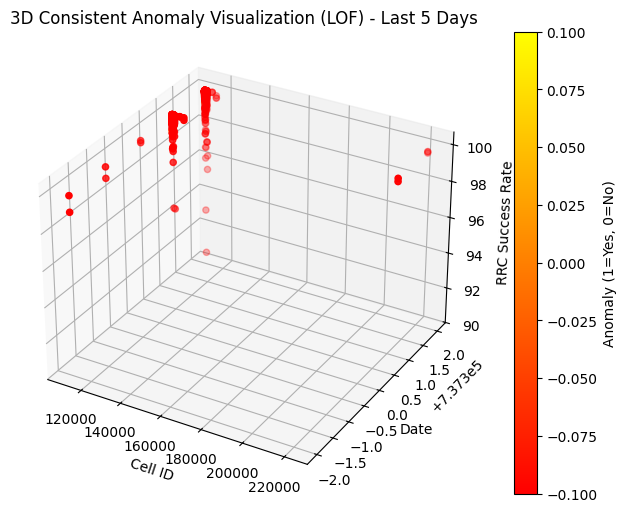

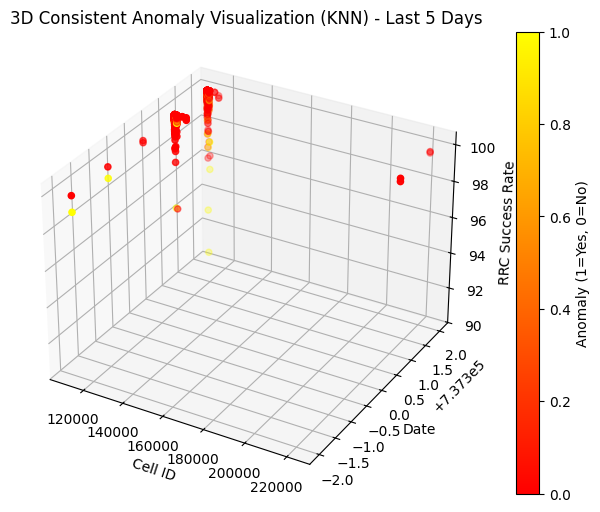

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor, NearestNeighbors
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score

from mpl_toolkits.mplot3d import Axes3D

# Load cleaned data
csv_path = 'RealData/AugestRawData/cleaned_kpi_data.csv'
df = pd.read_csv(csv_path, parse_dates=['Date'])

kpi_col = 'RRC Success Rate'

# 3-Sigma Rule for proxy anomaly labels (for evaluation only)
def label_spc_anomaly(series):
    mean = series.mean()
    std = series.std()
    return (series < mean - 3 * std).astype(int)

df['SPC_Anomaly'] = df.groupby('Cell ID')[kpi_col].transform(label_spc_anomaly)

# Models to compare
models = {
    'IsoForest': IsolationForest(random_state=42),
    'SVM': OneClassSVM(gamma='auto'),
    'LOF': LocalOutlierFactor(novelty=True),
    'KNN': None  # Will handle KNN separately
}

# Predict anomalies per Cell ID for each model
for model_name, model in models.items():
    for cell_id, group in df.groupby('Cell ID'):
        X = group[[kpi_col]].values
        if model_name == 'KNN':
            k = 5
            nbrs = NearestNeighbors(n_neighbors=k)
            nbrs.fit(X)
            distances, _ = nbrs.kneighbors(X)
            knn_score = distances[:, -1]
            threshold = np.percentile(knn_score, 95)
            preds = (knn_score > threshold).astype(int)
        else:
            try:
                preds = model.fit_predict(X)
                preds = (preds == -1).astype(int)
            except Exception:
                preds = np.zeros(X.shape[0], dtype=int)
        df.loc[group.index, f'{model_name}_Anomaly'] = preds

# Flag a cell as anomalous if it shows repetitive anomaly in the study period (e.g., at least 20% of days are anomalies)
min_ratio = 0.2  # Minimum ratio of anomaly days to flag as anomalous
cell_anomaly_results = {}
for model_name in models.keys():
    repetitive_anomaly = []
    for cell_id, group in df.groupby('Cell ID'):
        total_days = len(group)
        anomaly_days = group[f'{model_name}_Anomaly'].sum()
        is_anomalous = (anomaly_days / total_days) >= min_ratio
        repetitive_anomaly.append((cell_id, int(is_anomalous)))
    cell_anomaly_results[model_name] = pd.Series(dict(repetitive_anomaly))

# Ground truth: a cell is anomalous if at least 20% of days are 3-sigma anomalies
spc_repetitive = []
for cell_id, group in df.groupby('Cell ID'):
    total_days = len(group)
    anomaly_days = group['SPC_Anomaly'].sum()
    is_anomalous = (anomaly_days / total_days) >= min_ratio
    spc_repetitive.append((cell_id, int(is_anomalous)))
cell_anomaly_results['3-Sigma'] = pd.Series(dict(spc_repetitive))

# Collect metrics
metrics = {'Model': [], 'Precision': [], 'Recall': [], 'F1': []}
for model_name in models.keys():
    y_true = cell_anomaly_results['3-Sigma']
    y_pred = cell_anomaly_results[model_name]
    metrics['Model'].append(model_name)
    metrics['Precision'].append(precision_score(y_true, y_pred, zero_division=0))
    metrics['Recall'].append(recall_score(y_true, y_pred, zero_division=0))
    metrics['F1'].append(f1_score(y_true, y_pred, zero_division=0))
    print(f"\n{model_name} - Repetitive anomaly cell prediction report (≥{int(min_ratio*100)}% anomaly days):")
    print(classification_report(y_true, y_pred, zero_division=0))

# Plot model comparison
metrics_df = pd.DataFrame(metrics).set_index('Model')
metrics_df.plot(kind='bar', figsize=(8, 5))
plt.title(f'Repetitive Cell-level Anomaly Detection (≥{int(min_ratio*100)}% anomaly days)')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


# 3D plot for each model showing anomaly cells (last N days)
for model_name in models.keys():
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111, projection='3d')
    for cell_id, group in df.groupby('Cell ID'):
        group_sorted = group.sort_values('Date')
        last_n = group_sorted.tail(N)
        cell_ids = [int(cell_id)] * len(last_n)
        dates = pd.to_datetime(last_n['Date']).map(pd.Timestamp.toordinal)
        kpi_vals = last_n[kpi_col]
        colors = last_n[f'{model_name}_Anomaly']
        ax.scatter(cell_ids, dates, kpi_vals, c=colors, cmap='autumn', marker='o')
    ax.set_xlabel('Cell ID')
    ax.set_ylabel('Date')
    ax.set_zlabel(kpi_col)
    plt.title(f'3D Consistent Anomaly Visualization ({model_name}) - Last {N} Days')
    plt.colorbar(ax.collections[0], label='Anomaly (1=Yes, 0=No)')
    plt.show()